### **PHASE 1: Data Loading & Cleaning for Product Lifecycle Analysis**

In [1]:
# Step 1: Download necessary Python libraries
!pip install pandas
!pip install numpy

In [2]:
# Step 2: Import necessary Python libraries
import pandas as pd
import numpy as np

In [3]:
# Step 3: Upload the dataset file
from google.colab import files
uploaded = files.upload()

Saving Productlevel_Sales_Transactions_Dataset_Weekly.csv to Productlevel_Sales_Transactions_Dataset_Weekly.csv


In [4]:
# Step 4: Load uploaded Dataset
df = pd.read_csv("Productlevel_Sales_Transactions_Dataset_Weekly.csv")

In [7]:
# Step 5: Drop garbage columns
df = df.drop(columns=[col for col in df.columns if "unnamed" in col.lower() or col.strip() in ["", "94"]])

In [8]:
# Step 6: Clean column names
df.columns = df.columns.str.strip().str.lower()

In [9]:
# Step 7: Check the list of column names present in the dataset
print(df.columns)

Index(['scode', 'pcode', 'price', 'wk0', 'wk1', 'wk2', 'wk3', 'wk4', 'wk5',
       'wk6',
       ...
       'wk94', 'wk95', 'wk96', 'wk97', 'wk98', 'wk99', 'wk100', 'wk101',
       'wk102', 'wk103'],
      dtype='object', length=107)


In [11]:
# Step 8: Identify ID columns and week columns
id_columns = ['scode', 'pcode', 'price']
week_columns = [col for col in df.columns if col.startswith('wk')]

In [12]:
# Step 9: Convert from wide to long format
df_long = df.melt(id_vars=id_columns, value_vars=week_columns,
                  var_name='week', value_name='units')

In [13]:
# Step 10: Extract week number (e.g., wk0 → 0)
df_long['week_num'] = df_long['week'].str.extract(r'(\d+)').astype(int)

In [15]:
# Step 11: Create sale_date from week number (week 0 = 2022-01-03)
df_long['sale_date'] = pd.to_datetime("2022-01-03") + pd.to_timedelta(df_long['week_num'], unit='W')

In [17]:
# Step 12: Sort by product and date
df_long = df_long.sort_values(by=['scode', 'sale_date'])

In [18]:
# Step 13: Add product age (weeks since launch)
df_long['product_age_weeks'] = df_long.groupby('scode')['sale_date'].transform(lambda x: (x - x.min()).dt.days // 7)

In [19]:
# Step 14: Add cumulative units
df_long['cumulative_units'] = df_long.groupby('scode')['units'].cumsum()

In [20]:
# Step 15: Add 4-week moving average
df_long['units_ma_4w'] = df_long.groupby('scode')['units'].transform(lambda x: x.rolling(4, min_periods=1).mean())

In [21]:
# Step 16: Save the cleaned dataset
df_long.to_csv("Cleaned_SKU_Lifecycle.csv", index=False)
print("Cleaned file saved: Cleaned_SKU_Lifecycle.csv")

Cleaned file saved: Cleaned_SKU_Lifecycle.csv


In [22]:
# Step 17: Download the Cleaned dataset File
files.download("Cleaned_SKU_Lifecycle.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# Step 18: Preview
print(df_long.head(10))

    scode  pcode    price week  units  week_num  sale_date  product_age_weeks  \
0  Store1   SKU1  $24.00   wk0     23         0 2022-01-03                  0   
1  Store1   SKU2  $63.00   wk0     23         0 2022-01-03                  0   
2  Store1   SKU3  $93.00   wk0      7         0 2022-01-03                  0   
3  Store1   SKU4  $48.00   wk0     50         0 2022-01-03                  0   
4  Store1   SKU5  $62.00   wk0      8         0 2022-01-03                  0   
5  Store1   SKU6  $80.00   wk0     20         0 2022-01-03                  0   
6  Store1   SKU7  $95.00   wk0      4         0 2022-01-03                  0   
7  Store1   SKU8  $15.00   wk0      8         0 2022-01-03                  0   
8  Store1   SKU9  $55.00   wk0     14         0 2022-01-03                  0   
9  Store1  SKU10  $69.00   wk0     22         0 2022-01-03                  0   

   cumulative_units  units_ma_4w  
0                23    23.000000  
1                46    23.000000  
2  

### **PHASE 2: Product Lifecycle Visualization**

Code 1: Single SKU Lifecycle Plot

In [25]:
# Code 1: Step 1: Download necessary Python libraries
!pip install pandas
!pip install matplotlib

In [26]:
# Code 1: Step 2: Import necessary Python libraries
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
# Code 1: Step 3: Load cleaned lifecycle dataset
df = pd.read_csv("Cleaned_SKU_Lifecycle.csv", parse_dates=["sale_date"])

In [28]:
# Code 1: Step 4: Pick ONE SKU to visualize
sample_sku = df['scode'].unique()[0]
df_sku = df[df['scode'] == sample_sku]

In [29]:
# Code 1: Step 5: Add lifecycle stage for each row (based on product age in weeks)

def get_stage(age):
    if age < 10:
        return 'Introduction'
    elif age < 30:
        return 'Growth'
    elif age < 50:
        return 'Maturity'
    else:
        return 'Decline'

df_sku['stage'] = df_sku['product_age_weeks'].apply(get_stage)

/tmp/ipython-input-29-1322080582.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sku['stage'] = df_sku['product_age_weeks'].apply(get_stage)


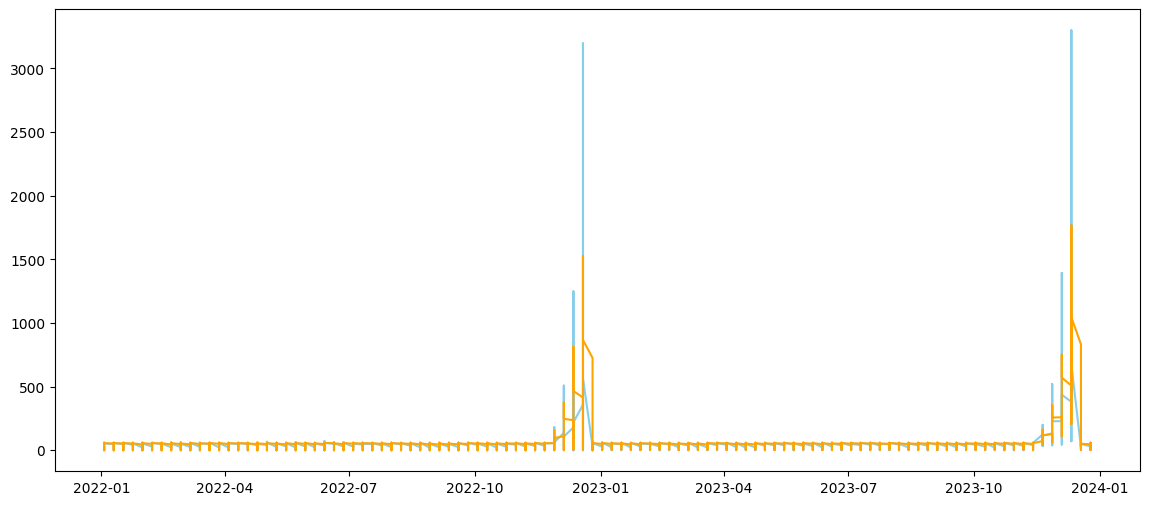

In [30]:
# Code 1: Step 6: Plot weekly units & 4-week moving average
plt.figure(figsize=(14, 6))
plt.plot(df_sku['sale_date'], df_sku['units'], label='Weekly Sales', color='skyblue')
plt.plot(df_sku['sale_date'], df_sku['units_ma_4w'], label='4-Week MA', color='orange')

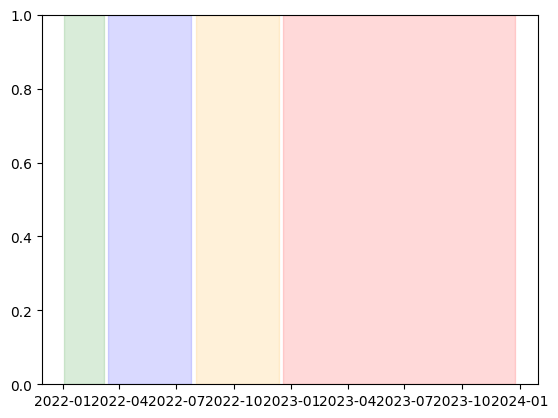

In [31]:
# Code 1: Step 7: Shade lifecycle stages
for stage, color in zip(['Introduction', 'Growth', 'Maturity', 'Decline'],
                        ['green', 'blue', 'orange', 'red']):
    stage_data = df_sku[df_sku['stage'] == stage]
    if not stage_data.empty:
        plt.axvspan(stage_data['sale_date'].min(), stage_data['sale_date'].max(),
                    color=color, alpha=0.15, label=stage)

/tmp/ipython-input-32-1727778776.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


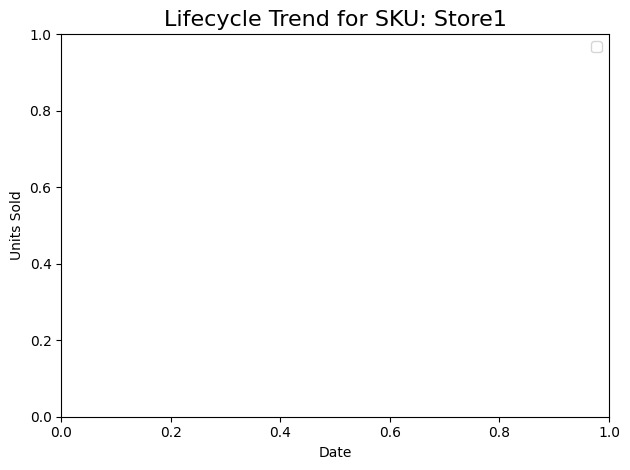

In [32]:
# Code 1: Step 8: Finalize plot
plt.title(f"Lifecycle Trend for SKU: {sample_sku}", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()

Code 2: Loop Through Multiple SKUs (Top 5)

In [33]:
# Code 2: Step 1: Download necessary Python libraries
!pip install pandas
!pip install matplotlib

In [34]:
# Code 2: Step 2: Import necessary Python libraries
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
# Code 2: Step 3: Load cleaned lifecycle dataset
df = pd.read_csv("Cleaned_SKU_Lifecycle.csv", parse_dates=["sale_date"])

In [36]:
# Code 2: Step 4: Define lifecycle stage logic (reused for all SKUs)

def get_stage(age):
    if age < 10:
        return 'Introduction'
    elif age < 30:
        return 'Growth'
    elif age < 50:
        return 'Maturity'
    else:
        return 'Decline'

df['stage'] = df['product_age_weeks'].apply(get_stage)

In [37]:
# Code 2: Step 5: Get all unique SKUs
sku_list = df['scode'].unique()

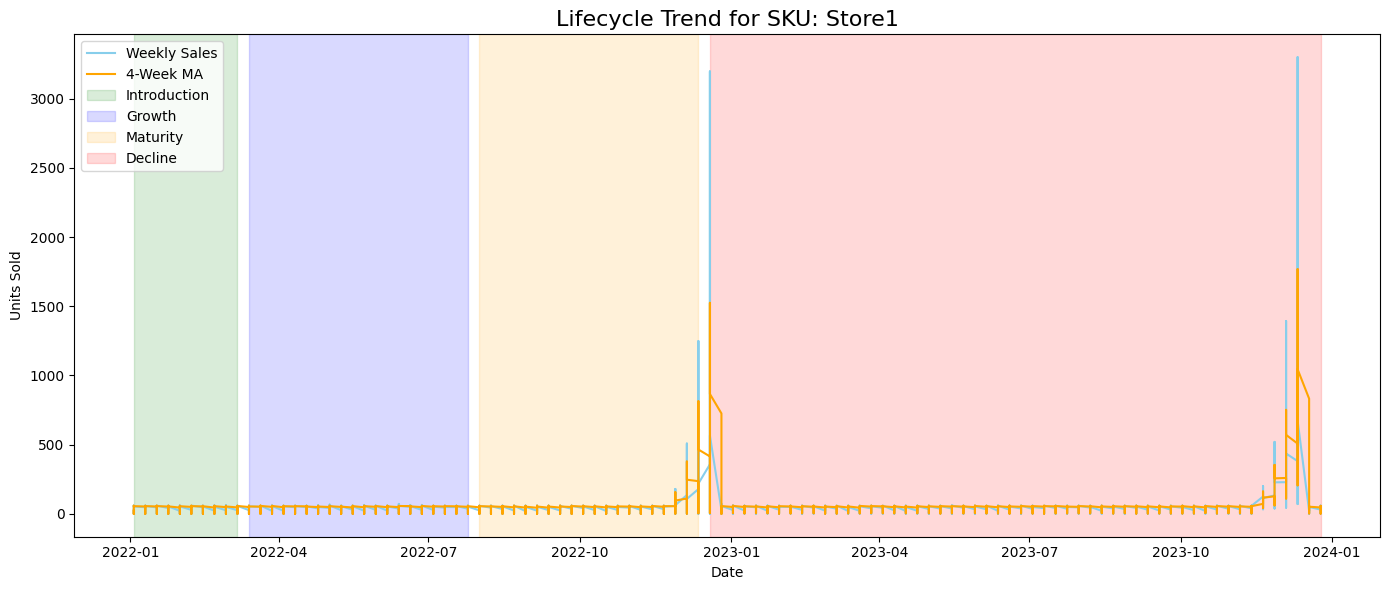

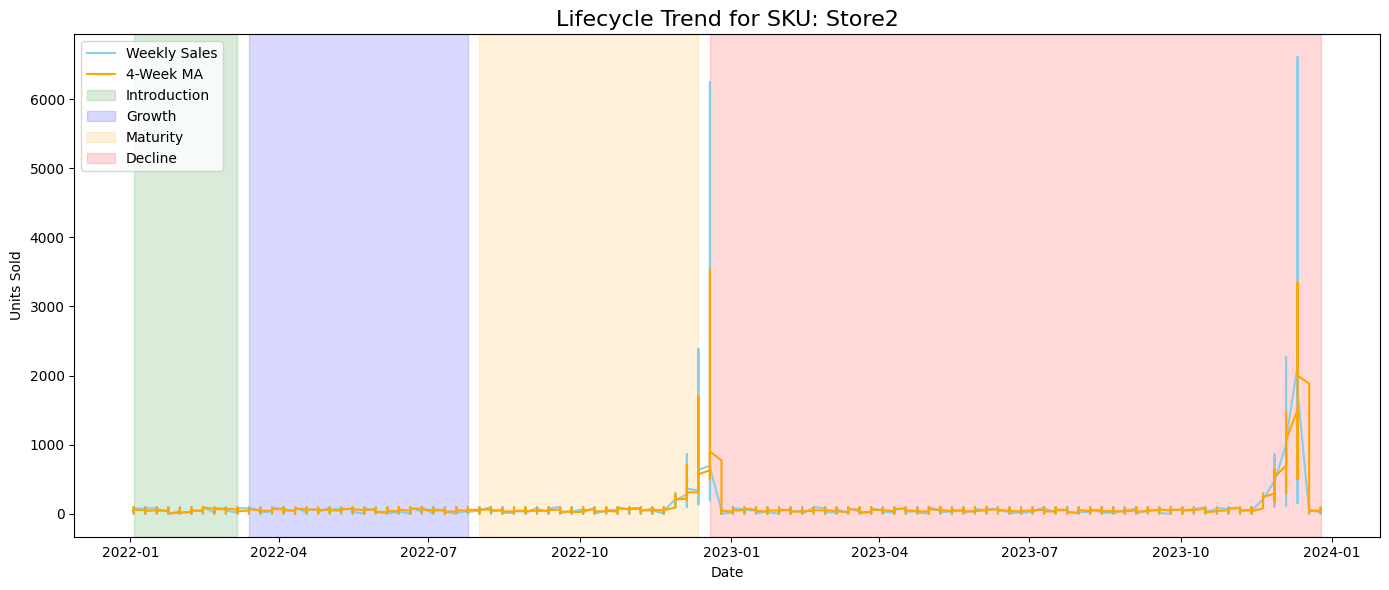

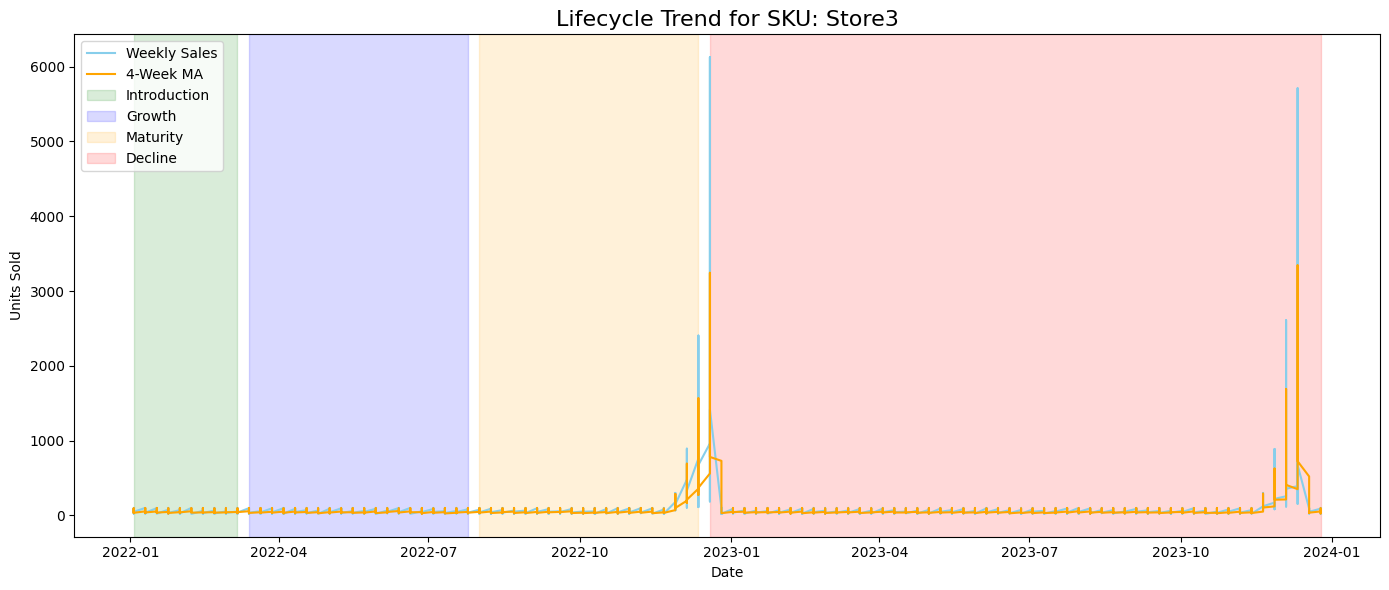

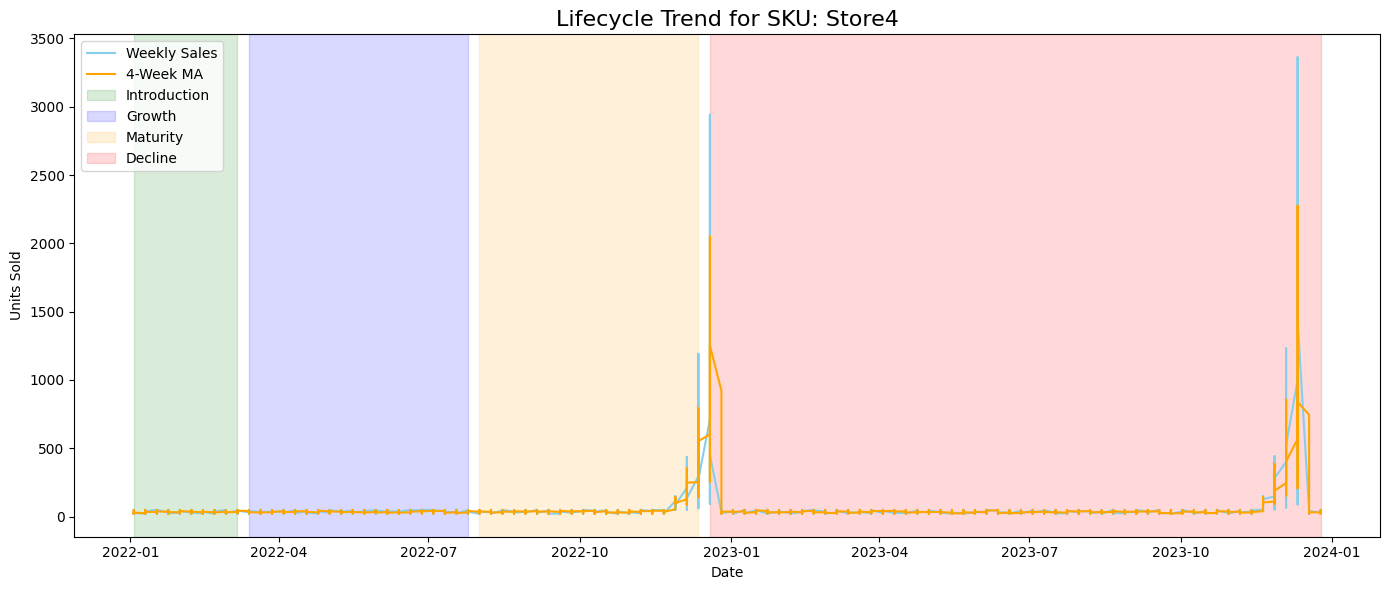

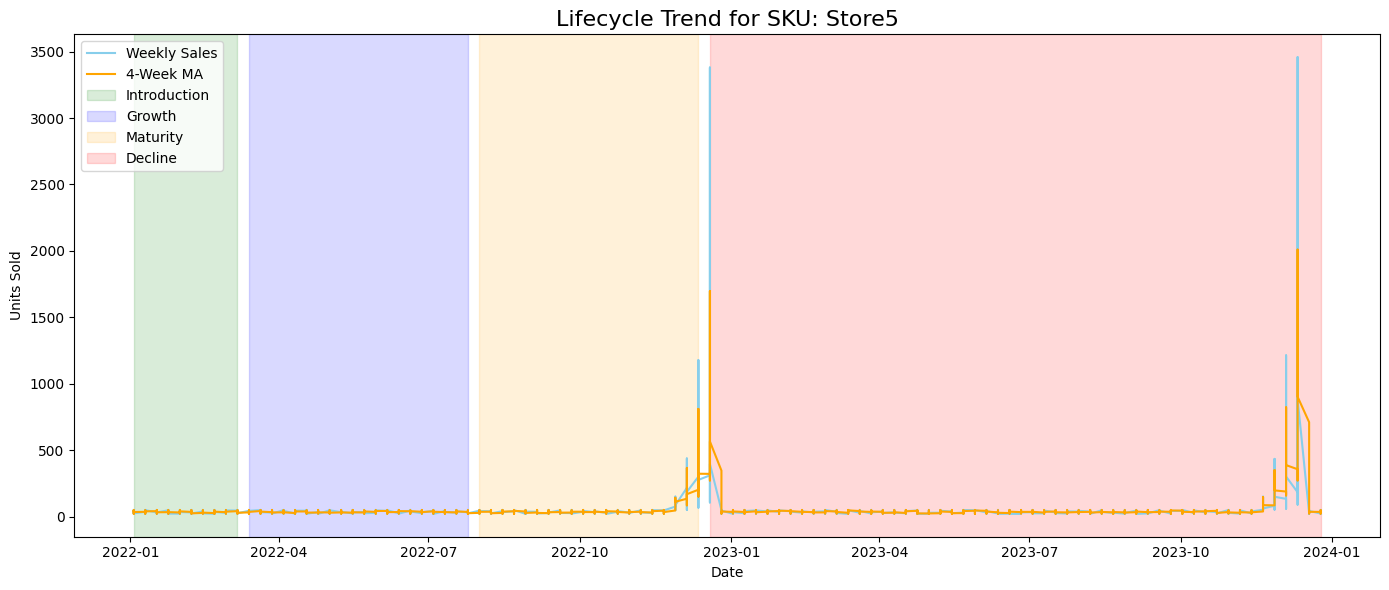

In [39]:
# Code 2: Step 6: Loop through first 5 SKUs (change [:5] to full range if needed)

#You can change 20 to any number — even len(sku_list) to loop through all SKUs.

for sku in sku_list[:5]:
    df_sku = df[df['scode'] == sku]

    plt.figure(figsize=(14, 6))
    plt.plot(df_sku['sale_date'], df_sku['units'], label='Weekly Sales', color='skyblue')
    plt.plot(df_sku['sale_date'], df_sku['units_ma_4w'], label='4-Week MA', color='orange')

    for stage, color in zip(['Introduction', 'Growth', 'Maturity', 'Decline'],
                            ['green', 'blue', 'orange', 'red']):
        stage_data = df_sku[df_sku['stage'] == stage]
        if not stage_data.empty:
            plt.axvspan(stage_data['sale_date'].min(), stage_data['sale_date'].max(),
                        color=color, alpha=0.15, label=stage)

    plt.title(f"Lifecycle Trend for SKU: {sku}", fontsize=16)
    plt.xlabel("Date")
    plt.ylabel("Units Sold")
    plt.legend()
    plt.tight_layout()
    plt.show()

### **PHASE 3: SKU-wise Lifecycle Classification**

In [40]:
# Step 1: Download necessary Python libraries
!pip install pandas
!pip install numpy

In [41]:
# Step 2: Import necessary Python libraries
import pandas as pd
import numpy as np

In [93]:
# Step 3: Load the cleaned dataset
df_long = pd.read_csv("Cleaned_SKU_Lifecycle.csv", parse_dates=["sale_date"])

In [94]:
# Step 6: Remove missing or invalid data based on 'units' and ensure non-negative sales
df_long = df_long[df_long['units'].notna()] # Filter by the 'units' column
df_long = df_long[df_long['units'] >= 0]
display(df_long.head()) # Display the head of the filtered dataframe

,scode,pcode,price,week,units,week_num,sale_date,product_age_weeks,cumulative_units,units_ma_4w
0,Store1,SKU1,$24.00,wk0,23,0,2022-01-03,0,23,23.000000
1,Store1,SKU2,$63.00,wk0,23,0,2022-01-03,0,46,23.000000
2,Store1,SKU3,$93.00,wk0,7,0,2022-01-03,0,53,17.666667
3,Store1,SKU4,$48.00,wk0,50,0,2022-01-03,0,103,25.750000
4,Store1,SKU5,$62.00,wk0,8,0,2022-01-03,0,111,22.000000


In [95]:
# Step 7: Define lifecycle classification function
def classify_lifecycle(df_long):
    results = []

    for (scode, pcode), group in df_long.groupby(['scode', 'pcode']):
        group = group.sort_values('week_num') # Sort by week_num from cleaned data

        # Aggregate weekly sales
        sales_series = group['units'].reset_index(drop=True) # Use 'units' column from cleaned data

        if sales_series.sum() == 0:
            continue  # Skip products with no sales at all

        # Normalize for analysis
        normalized_sales = sales_series / sales_series.max()

        # Define lifecycle stages based on thresholds
        # Ensure indices are within bounds after filtering NaNs
        growth_start_idx = (normalized_sales > 0.2).idxmax() if (normalized_sales > 0.2).any() else 0
        maturity_start_idx = (normalized_sales > 0.7).idxmax() if (normalized_sales > 0.7).any() else growth_start_idx
        decline_start_idx = (normalized_sales[::-1] < 0.3).idxmax() if (normalized_sales[::-1] < 0.3).any() else len(sales_series) - 1
        decline_start_idx = len(sales_series) - 1 - decline_start_idx


        result = {
            'scode': scode,
            'pcode': pcode,
            'intro_week': group['week_num'].min(), # Use week_num
            'growth_start_week': group.iloc[growth_start_idx]['week_num'], # Use week_num
            'maturity_start_week': group.iloc[maturity_start_idx]['week_num'], # Use week_num
            'decline_start_week': group.iloc[decline_start_idx]['week_num'], # Use week_num
            'total_sales': sales_series.sum()
        }
        results.append(result)

    if not results:
        raise ValueError("No valid SKU groups to classify.")

    return pd.DataFrame(results)

In [96]:
# Step 8: Run lifecycle classification
df_lifecycle = classify_lifecycle(df_long)

In [97]:
# Step 9: View the classified lifecycle
df_lifecycle.head()

,scode,pcode,intro_week,growth_start_week,maturity_start_week,decline_start_week,total_sales
0,Store1,SKU1,0,48,50,0,4789
1,Store1,SKU10,0,49,101,0,3357
2,Store1,SKU100,0,49,50,0,3285
3,Store1,SKU1000,0,48,50,0,10215
4,Store1,SKU1001,0,47,50,0,8584


### **PHASE 4: Monthly Sales Aggregation and Visualization**

In [99]:
# Step 1: Download necessary Python libraries
!pip install pandas
!pip install matplotlib

In [100]:
# Step 2: Import necessary Python libraries
import pandas as pd
import matplotlib.pyplot as plt

In [101]:
# Step 3: Convert 'week' column (e.g., 'wk0') to integer
df_long['week'] = df_long['week'].str.extract(r'(\d+)').astype(int)

In [102]:
# Step 4: Create a 'month' column by grouping every 4 weeks
df_long['month'] = df_long['week'] // 4

In [103]:
# Step 5: Aggregate monthly sales per SKU (scode + pcode)
monthly_sales = df_long.groupby(['scode', 'pcode', 'month'])['units'].sum().reset_index()

In [104]:
# Step 6: Plot sales trends for top N SKUs (by total sales volume)
top_skus = (
    monthly_sales.groupby(['scode', 'pcode'])['units']
    .sum()
    .sort_values(ascending=False)
    .head(10)  # change this to 20 if needed
    .reset_index()
)

In [105]:
# Step 7: Filter only top SKUs for plotting
filtered_sales = pd.merge(monthly_sales, top_skus, on=['scode', 'pcode'], how='inner', suffixes=('', '_total'))

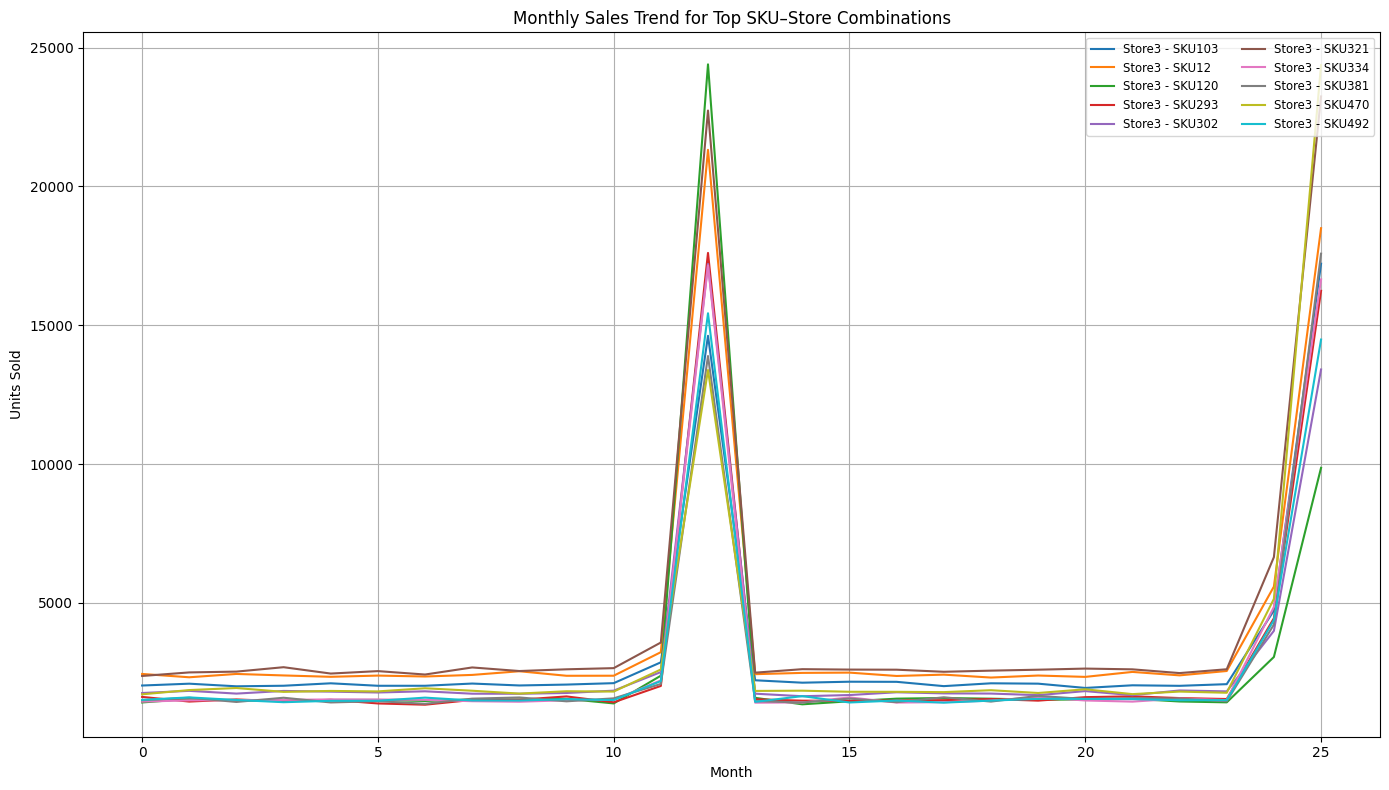

In [107]:
# Step 8: Plot
plt.figure(figsize=(14, 8))

for (scode, pcode), group in filtered_sales.groupby(['scode', 'pcode']):
    label = f"{scode} - {pcode}"
    plt.plot(group['month'], group['units'], label=label)

plt.title('Monthly Sales Trend for Top SKU–Store Combinations')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

### **PHASE 5: Lifecycle Stage Labeling and Visualization**

In [108]:
# Step 1: Download necessary Python libraries
!pip install seaborn
!pip install matplotlib

In [109]:
# Step 2: Import necessary Python libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [111]:
# Step 3: Choose top N SKUs by total sales
top_skus = (
    df_lifecycle.groupby(['scode', 'pcode'])['total_sales'] # Changed 'units' to 'total_sales'
    .sum()
    .sort_values(ascending=False)
    .head(6)  # adjust top N here
    .reset_index()
)

In [112]:
# Step 4: Filter the lifecycle data to include only those top SKUs
df_top = pd.merge(df_lifecycle, top_skus, on=['scode', 'pcode'], how='inner')

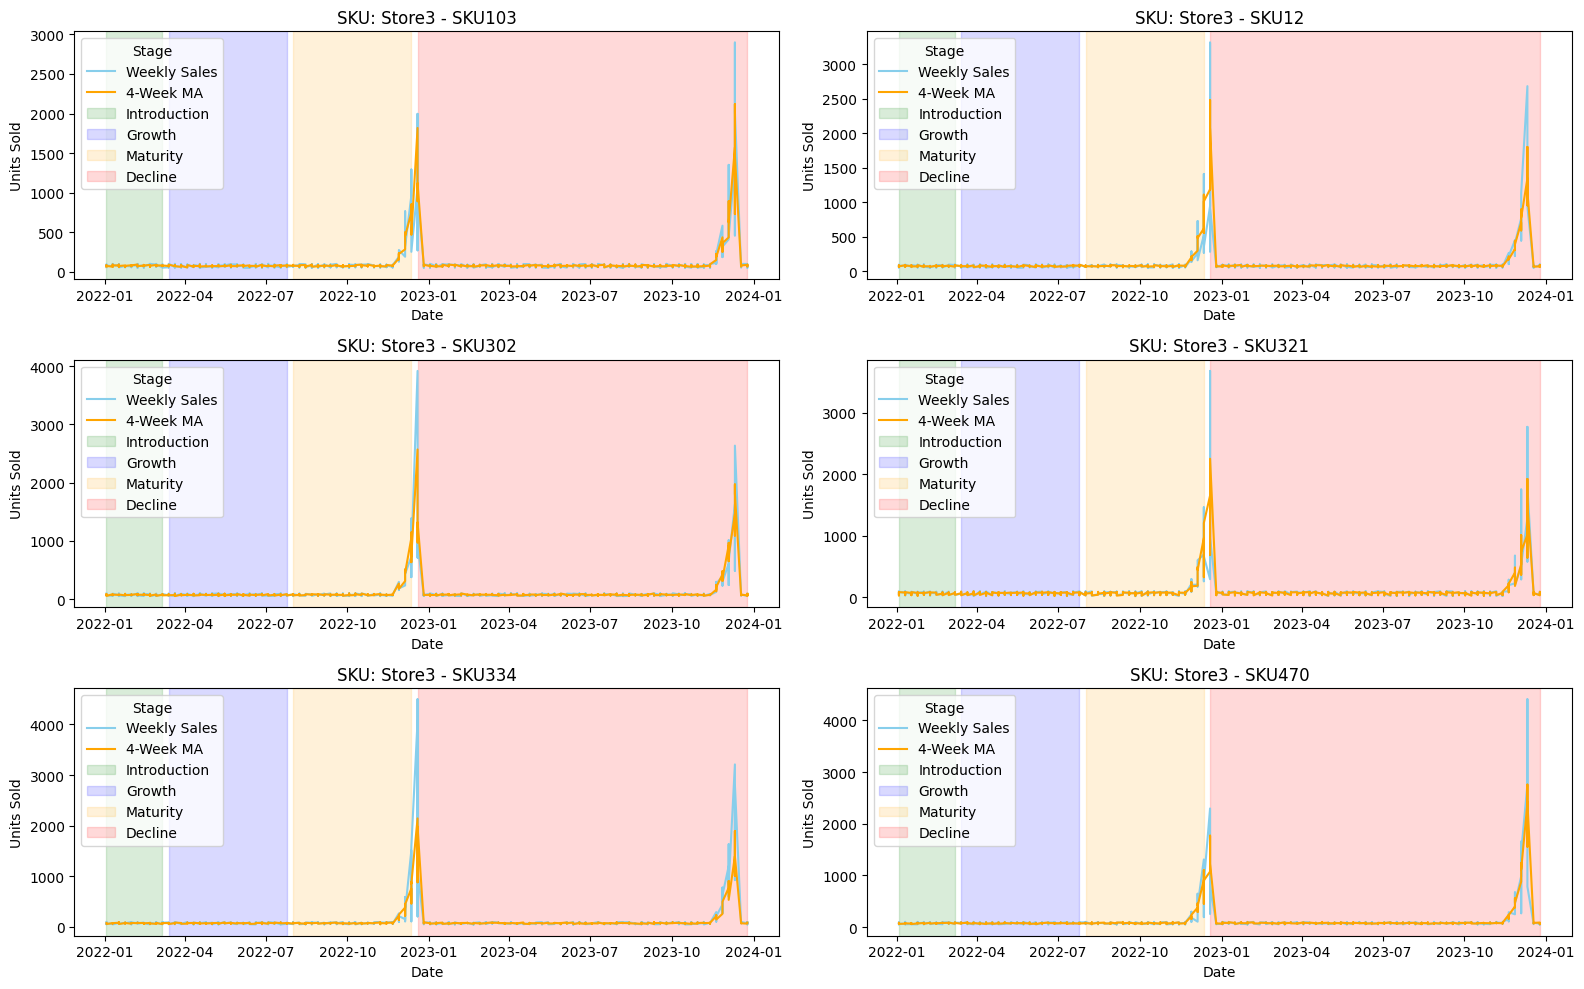

In [114]:
# Step 5: Plot lifecycle stages with color-coded lines

# Merge df_long with top_skus to get weekly sales data for top SKUs
df_plot = pd.merge(df_long, top_skus[['scode', 'pcode']], on=['scode', 'pcode'], how='inner')

# Define lifecycle stage logic (reused for all SKUs)
def get_stage(age):
    if age < 10:
        return 'Introduction'
    elif age < 30:
        return 'Growth'
    elif age < 50:
        return 'Maturity'
    else:
        return 'Decline'

df_plot['lifecycle_stage'] = df_plot['product_age_weeks'].apply(get_stage)


plt.figure(figsize=(16, 10))
for i, ((scode, pcode), group) in enumerate(df_plot.groupby(['scode', 'pcode'])):
    plt.subplot(3, 2, i+1)  # change layout based on N SKUs
    group = group.sort_values('week_num') # Sort by week_num

    # Plot weekly units
    plt.plot(group['sale_date'], group['units'], label='Weekly Sales', color='skyblue')

    # Plot 4-week moving average
    plt.plot(group['sale_date'], group['units_ma_4w'], label='4-Week MA', color='orange')

    # Shade lifecycle stages
    for stage, color in zip(['Introduction', 'Growth', 'Maturity', 'Decline'],
                            ['green', 'blue', 'orange', 'red']):
        stage_data = group[group['lifecycle_stage'] == stage]
        if not stage_data.empty:
            plt.axvspan(stage_data['sale_date'].min(), stage_data['sale_date'].max(),
                        color=color, alpha=0.15, label=stage)


    plt.title(f'SKU: {scode} - {pcode}')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend(title='Stage', loc='best')

plt.tight_layout()
plt.show()

### **PHASE 6: Lifecycle Duration Comparison & Decision Flags**

In [121]:
# Step 1: Add lifecycle stage to df_long
def get_stage(age):
    if age < 10:
        return 'Introduction'
    elif age < 30:
        return 'Growth'
    elif age < 50:
        return 'Maturity'
    else:
        return 'Decline'

df_long['lifecycle_stage'] = df_long['product_age_weeks'].apply(get_stage)

In [122]:
# Step 2: Count how many weeks each SKU spent in each lifecycle stage
stage_counts = (
    df_long.groupby(['scode', 'pcode', 'lifecycle_stage'])['week_num'] # Changed to use df_long and week_num
    .count()
    .reset_index()
    .rename(columns={'week_num': 'weeks_in_stage'}) # Renamed the counted column
)

In [123]:
# Step 3: Pivot the stages into columns
lifecycle_summary = stage_counts.pivot(
    index=['scode', 'pcode'],
    columns='lifecycle_stage',
    values='weeks_in_stage'
).fillna(0).reset_index()

In [124]:
# Step 4: Ensure column order
expected_stages = ['Introduction', 'Growth', 'Maturity', 'Decline']
for stage in expected_stages:
    if stage not in lifecycle_summary.columns:
        lifecycle_summary[stage] = 0


In [125]:
# Step 5: Total active weeks
lifecycle_summary['total_weeks'] = lifecycle_summary[expected_stages].sum(axis=1)

In [126]:
# Step 6: Business Decision Rule Logic

def decision_rule(row):
    if row['Decline'] >= 8 and row['Maturity'] <= 4:
        return 'Discontinue'
    elif row['Growth'] >= 6 and row['Maturity'] < 3:
        return 'Promote'
    elif row['Maturity'] >= 10:
        return 'Restock'
    else:
        return 'Monitor'

lifecycle_summary['business_decision'] = lifecycle_summary.apply(decision_rule, axis=1)

In [127]:
# Step 7: Show the output
print(lifecycle_summary.head(10))

lifecycle_stage   scode    pcode  Decline  Growth  Introduction  Maturity  \
0                Store1     SKU1       54      20            10        20   
1                Store1    SKU10       54      20            10        20   
2                Store1   SKU100       54      20            10        20   
3                Store1  SKU1000       54      20            10        20   
4                Store1  SKU1001       54      20            10        20   
5                Store1  SKU1002       54      20            10        20   
6                Store1  SKU1003       54      20            10        20   
7                Store1  SKU1004       54      20            10        20   
8                Store1  SKU1005       54      20            10        20   
9                Store1  SKU1006       54      20            10        20   

lifecycle_stage  total_weeks business_decision  
0                        104           Restock  
1                        104           Restock  
2    

### **PHASE 7: Visualization**

In [128]:
# Step 1: Download necessary Python library
!pip install plotly

In [129]:
# Step 2: Import necessary Python library
import plotly.express as px

In [130]:
# Step 3: Bar Chart — Business Decisions by Store
fig = px.bar(
    lifecycle_summary,
    x='business_decision',
    color='scode',
    title='Business Decisions by Store',
    barmode='group'
)
fig.show()

In [131]:
# Step 4: Stacked Bar — Lifecycle Weeks per SKU
fig = px.bar(
    lifecycle_summary,
    x='pcode',
    y=['Introduction', 'Growth', 'Maturity', 'Decline'],
    title='Lifecycle Stage Breakdown per Product',
    labels={'value':'Weeks', 'pcode':'Product Code'},
    color_discrete_sequence=px.colors.qualitative.Set3
)
fig.update_layout(barmode='stack')
fig.show()


In [132]:
# Step 4: Pie Chart — Decision Distribution
fig = px.pie(
    lifecycle_summary,
    names='business_decision',
    title='Overall Business Decision Share',
    hole=0.4  # makes it donut-style
)
fig.show()


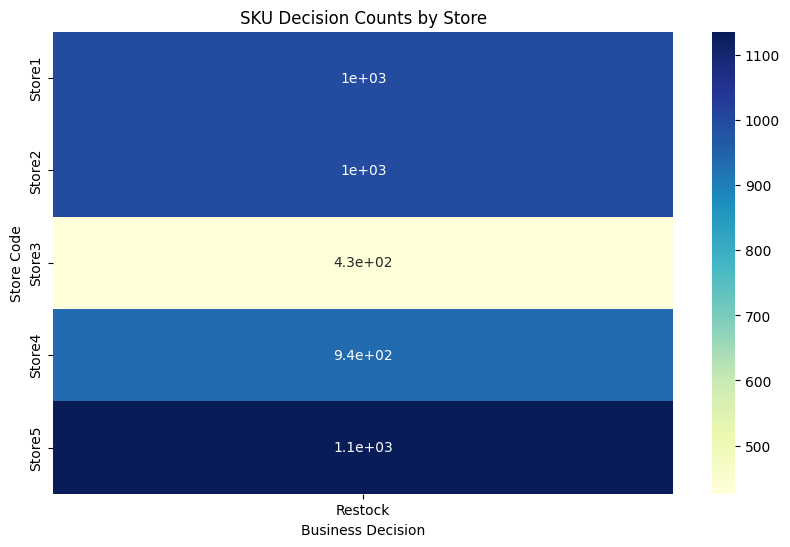

In [133]:
# Step 5: Heatmap — Store vs Business Decision

heat_data = lifecycle_summary.groupby(['scode', 'business_decision']).size().unstack(fill_value=0)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(heat_data, annot=True, cmap='YlGnBu')
plt.title('SKU Decision Counts by Store')
plt.ylabel('Store Code')
plt.xlabel('Business Decision')
plt.show()


In [134]:
# Step 6: Import necessary Python library
import plotly.graph_objects as go

In [136]:
# Step 7: Display Table in Colab

fig = go.Figure(data=[go.Table(
    header=dict(values=list(lifecycle_summary.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[lifecycle_summary[col] for col in lifecycle_summary.columns],
               fill_color='lavender',
               align='left'))
])

fig.update_layout(title='Lifecycle Summary Table')
fig.show()

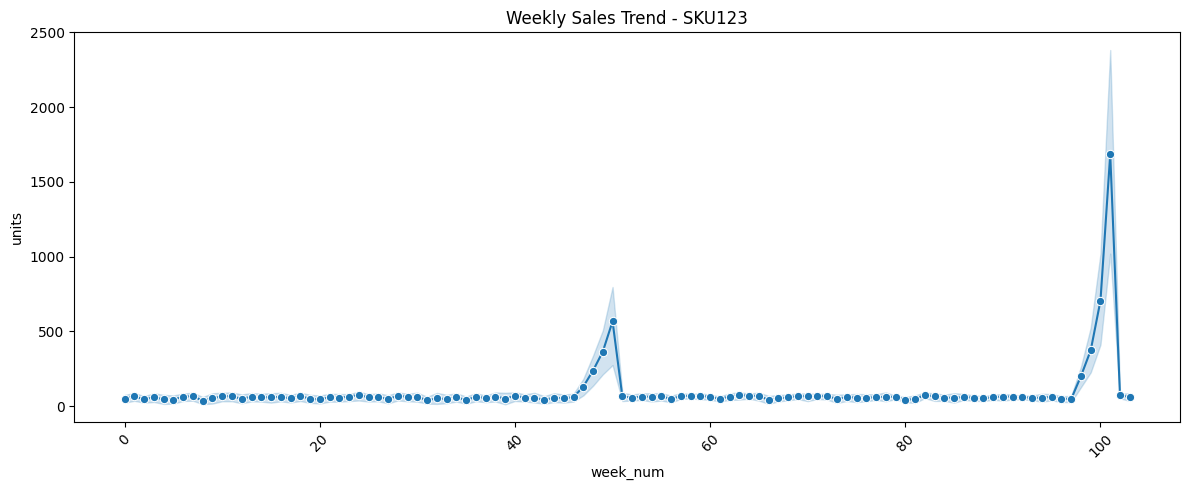

In [140]:
# Step 8: Save Time Series Trend per SKU

# You can save line plots of SKU sales trends (from df_long) showing transitions across lifecycle stages.

# Example for one SKU
sku = 'SKU123'  # replace as needed
df_sku = df_long[df_long['pcode'] == sku] # Filter by 'pcode' as SKUs are identified by pcode

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_sku, x='week_num', y='units', marker='o') # Changed 'week' to 'week_num' and 'sales' to 'units'
plt.title(f"Weekly Sales Trend - {sku}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"sku_trend_{sku}.png")